In [1]:
import itertools
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
from math import log

# visualization
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

from catboost import CatBoostClassifier, Pool, cv
import hyperopt
from numpy.random import RandomState

from sklearn.model_selection import train_test_split, GridSearchCV
# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# classifiers
from sklearn.naive_bayes import GaussianNB # naive bayes
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision Tree
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier

import preprocessing

In [18]:
#Import data
xtrain = pd.read_csv("Xtrain.csv")
ytrain = pd.read_csv("Ytrain.csv")
records = xtrain.copy()
records['ChargeOff'] = ytrain['ChargeOff']
records.head()

,Id,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,ChargeOff
0,0,"NPE Realty, LLC",Pembroke Pines,FL,33027,"TD BANK, NATIONAL ASSOCIATION",DE,334516,16-Apr-10,2010,...,0,1,N,N,1-May-10,"$2,000,000.00",$0.00,"$2,000,000.00","$1,500,000.00",0
1,1,"KEVCO CONSTRUCTION, LLC",SANDY,UT,84094,ZIONS FIRST NATIONAL BANK,UT,236115,30-Jan-10,2010,...,0,1,N,N,1-Feb-10,"$17,000.00",$0.00,"$17,000.00","$17,000.00",1
2,2,EAST L A SHOE REPAIR,LOS ANGELES,CA,90022,BANK OF AMERICA NATL ASSOC,NC,811430,29-Jul-02,2002,...,1,1,Y,N,31-Aug-02,"$17,000.00",$0.00,"$17,000.00","$8,500.00",0
3,3,"RUSSLER, DANIEL C, MD",LODI,WI,53555,ASSOCIATED BANK NATL ASSOC,WI,0,10-Jun-94,1994,...,1,0,N,N,31-Jul-94,"$137,000.00",$0.00,"$137,000.00","$123,300.00",0
4,4,AFFORDABLE FAMILY DENISTRY LLC,LEBANON,MO,65536,COMMERCE BANK,MO,621210,6-Feb-06,2006,...,1,1,T,N,31-Mar-06,"$46,665.00",$0.00,"$25,000.00","$12,500.00",0


### Data Prepocessing

In [19]:
records = preprocessing.all_preprocess_without_label_encoding(records)
CAT_FEATURES = ['City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'ApprovalDate', 'ApprovalFY',
                'NewExist', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'DisbursementDate', 'Recession']

### Data Transformation

In [4]:
x1 = records.drop(columns='ChargeOff')
y1 = records['ChargeOff']
x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size = 0.25, random_state=0)
x1.head()

,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,...,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,GrAppv,SBA_Appv,Recession,GrAppv_SBAAppv
0,Pembroke Pines,FL,33027,"TD BANK, NATIONAL ASSOCIATION",DE,MANUFACTURING,16-Apr-10,2010,130,25,...,N,1,N,N,1-May-10,2000000.0,2000000.0,1500000.0,N,0.75
1,SANDY,UT,84094,ZIONS FIRST NATIONAL BANK,UT,CONSTRUCTION,30-Jan-10,2010,33,6,...,N,1,N,N,1-Feb-10,17000.0,17000.0,17000.0,N,1.00
2,LOS ANGELES,CA,90022,BANK OF AMERICA NATL ASSOC,NC,OTHER_SERVICES,29-Jul-02,2002,60,1,...,N,1,Y,N,31-Aug-02,17000.0,17000.0,8500.0,N,0.50
3,LODI,WI,53555,ASSOCIATED BANK NATL ASSOC,WI,NONE,10-Jun-94,1994,160,1,...,N,0,N,N,31-Jul-94,137000.0,137000.0,123300.0,Y,0.90
4,LEBANON,MO,65536,COMMERCE BANK,MO,HEALTHCARE,6-Feb-06,2006,101,2,...,N,1,Y,N,31-Mar-06,46665.0,25000.0,12500.0,Y,0.50


### Train model
- the choice of categofical features matters

In [20]:
model = CatBoostClassifier(
    l2_leaf_reg=7,
    learning_rate=0.17563256864315815,
    depth=8,
    iterations=750,
    random_seed=51,
    eval_metric='Accuracy',
    verbose=False,
    loss_function='Logloss')
model.fit(x_train,y_train,
         cat_features=CAT_FEATURES,
         eval_set=(x_test, y_test),
         logging_level='Silent',
         plot=False)

In [21]:
accuracy_score(y_test, model.predict(x_test))

0.93624

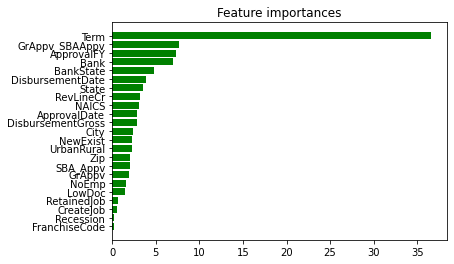

In [41]:
feature_import = list(zip(x_train.columns,model.feature_importances_))
df = pd.DataFrame(columns=['Feature', 'Importance'], data=feature_import)
df=df.sort_values(by=['Importance'])
plt.figure()
plt.title("Feature importances")
plt.barh(df['Feature'], df['Importance'],
       color="g", align="center", )
plt.savefig('catboost.png', bbox_inches='tight')

### Train model with best params

In [30]:
model = CatBoostClassifier(
    l2_leaf_reg=7,
    learning_rate=0.17563256864315815,
    depth=8,
    iterations=750,
    random_seed=51,
    eval_metric='Accuracy',
    verbose=False,
    loss_function='Logloss')
model.fit(x1, y1, cat_features=CAT_FEATURES)

### Predict

In [31]:
X_test = pd.read_csv('Xtest.csv')
X_testset = preprocessing.all_preprocess_without_label_encoding(X_test)

In [33]:
# there maybe nan values in other columns after processing
for col in X_testset:
    dt = X_testset[col].dtype 
    if dt == int or dt == float:
        X_testset[col].fillna(0, inplace=True)
    else:
        X_testset[col].fillna("", inplace=True)

In [34]:
import pandas as pd
submisstion = pd.DataFrame()
submisstion['Id'] = X_test['Id']
submisstion['ChargeOff'] = model.predict(X_testset)

In [35]:
submisstion.to_csv('submission.csv', index=False)